In [35]:
import numpy as np, cv2, sys, glob, os, matplotlib.pyplot as plt , random

def get_input(folderName):
    fileNames, images = [], []
    path = os.path.join(folderName, '*')
    for fn in glob.glob(path):
        fileNames.append(fn)
    fileNames.sort()
    for fn in fileNames:
        images.append(cv2.imread(fn))
    return fileNames, images

In [2]:
def get_matches(des1, des2):
    FLANN_INDEX_KDTREE = 0
    flann = cv2.FlannBasedMatcher(dict(algorithm = 0, trees = 5), dict(checks = 50))
    var = 2
    m = flann.knnMatch(des1, des2, k = var)
    return m

In [3]:
def show_matches(matches, img1, kp1, img2, kp2, idx, folderName):
    matchesMask = [[0,0] for i in range(len(matches))]

    itr = enumerate(matches)
    for i, (m,n) in itr:
        dist = 0.3 * n.distance
        if m.distance >= dist:
            pass
        else:
            matchesMask[i] = [1,0]

    color_mask_1, color_mask_2, var = (0, 255, 0), (255, 0, 0), 0

    draw_params = dict(matchColor = color_mask_1,
                       singlePointColor = color_mask_2,
                       matchesMask = matchesMask,
                       flags = var)

    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
    fname = folderName
    fname = fname + str(idx)
    fname = fname + '.png'
    cv2.imwrite(fname,img3)


In [4]:
def matches_error(matches):
    goodMatch=[]
    for m_n in matches:
        my_len = len(m_n)
        if my_len == 2:
            pass
        else:
            continue
        m, n = m_n
        dist = 0.75 * n.distance
        if m.distance >= dist:
            pass
        else:
            goodMatch.append(m)
    return goodMatch

In [5]:
def get_match_points(goodMatches):
    tp, qp, c, matchPoints = [], [], 0, []
    for m in goodMatches:
        c += 1
        wht, lht = kp1[m.queryIdx].pt, kp2[m.trainIdx].pt
        tp.append(wht)
        qp.append(lht)
    tp, qp = np.float32((tp, qp))
    itr = tp.shape[0]
    for i in range(itr):
        a = []
        a.extend([tp[i][0], tp[i][1], qp[i][0], qp[i][1]])
        matchPoints.append(a)
    matchPoints = np.array(matchPoints)
    return matchPoints, qp, tp

In [6]:
def homographyCalculation(impPoints):
    assemble, rng = [], 4
    for i in range(rng):
        point1, point2, a1, a2 =  [], [], [], []
        point1.extend([impPoints[i][0], impPoints[i][1], 1])
        point2.extend([impPoints[i][2], impPoints[i][3], 1])
        fst, scd, thd, frth = point1[0] * point2[0], point1[1] * point2[0], point1[0] * point2[1], point1[1] * point2[1]
        a1.extend([-point1[0], -point1[1], -1, 0, 0, 0, fst, scd, point2[0]])
        a2.extend([0, 0, 0, -point1[0], -point1[1], -1, thd, frth, point2[1]])
        assemble.append(a2)
        assemble.append(a1)
    ax = (3, 3)
    assemble = np.matrix(assemble)
    u, s, v = np.linalg.svd(assemble)
    req = v[8]
    h = np.reshape(req, ax)
    h = (1/h.item(8)) * h
    return h

In [7]:
def dist(points, h):
    point1 = []
    point1.extend([points[0], points[1], 1])
    a = np.matrix(point1)
    point1 = np.transpose(a)
    predictedP2 = np.dot(h, point1)
    predictedP2 = predictedP2 * (1/predictedP2[2])
    point2 = []
    point2.extend([points[2], points[3], 1])
    a = np.matrix(point2)
    point2 = np.transpose(a)
    a = point2 - predictedP2
    ret = np.linalg.norm(a)
    return ret

In [8]:
def ransac(matchPoints, qp, tp):
    rng, sol, hom = 100, [], None
    for i in range(rng):
        impPoints, inliers = [], []
        rng_2 = 4
        for j in range(rng_2):
            shp = matchPoints.shape[0] - 1
            idx = random.randint(1, shp)
            onePoint = []
            onePoint.extend([matchPoints[idx][0], matchPoints[idx][1], matchPoints[idx][2], matchPoints[idx][3]])
            impPoints.append(onePoint)
        impPoints = np.array(impPoints)
        h = homographyCalculation(impPoints)
        shp = matchPoints.shape[0]
        for k in range(shp):
            if(dist(matchPoints[k], h) >= 50):
                pass
            else:
                inliers.append(matchPoints[k])
        ln1, ln2 = len(inliers), len(sol)
        if(ln1 <= ln2):
            pass
        else:
            hom, sol = h, inliers
    var = 4
    H, __ = cv2.findHomography(qp, tp, cv2.RANSAC, var)
    return H
    

In [9]:
        
def get_warped_image(img1, img2, H, i, folderName):
    inp = (img1.shape[1] + img2.shape[1], img1.shape[0])
    result = cv2.warpPerspective(img2, H, inp)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.imshow(result), plt.show()
    fname = folderName
    fname = fname + 'warped_'
    result[0:img1.shape[0], 0:img1.shape[1]] = img1
    fname = fname + str(i)
    fname = fname + '.png'
    cv2.imwrite(fname, result)
    sz = (16, 16)
    plt.figure(figsize=sz)
    plt.imshow(result), plt.show()
    return result

In [10]:
def getSize(result):
    i, c = 0, 0
    comp, SZ = 0, 50
    while not (c >= SZ) and i<result.shape[1] :
        if(result[SZ][i][0] == comp and result[SZ][i][1] == comp and result[SZ][i][2] == comp):
            c += 1
        else:
            c = 0
        i += 1
    cols = i - 50
    return cols

0


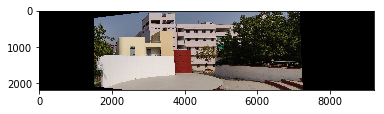

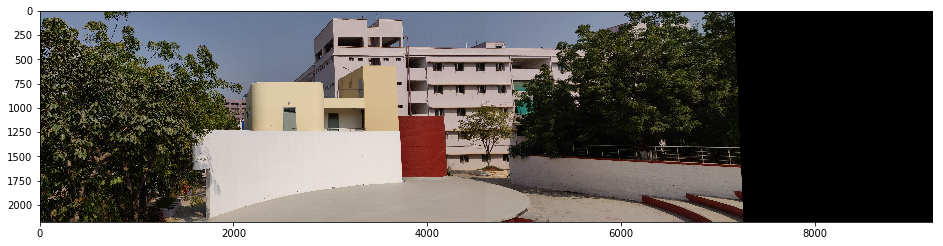

1


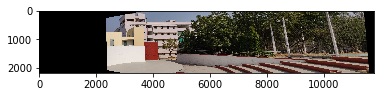

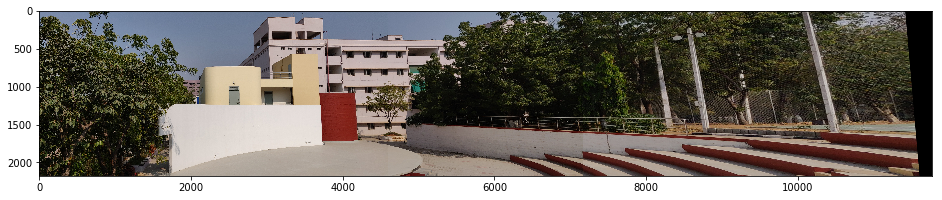

2


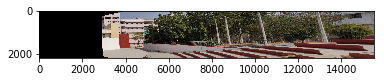

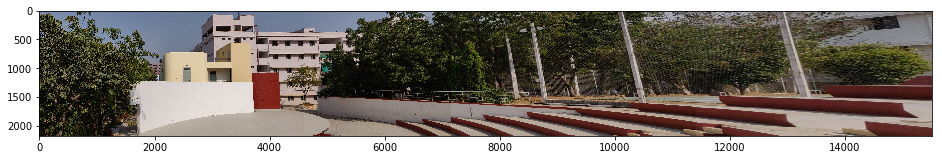

In [11]:
import cv2
nm = './images/image_mosaicing/1/'
fileNames, images = get_input(nm)
surf = cv2.xfeatures2d.SURF_create()
img1 = images[0]
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
lnth = len(fileNames) - 1
for i in range(lnth):
    print(i)
    img2 = images[i+1]
    senital = None
    kp1, des1 = surf.detectAndCompute(img1, senital)
    kp2, des2 = surf.detectAndCompute(img2, senital)
    matches = get_matches(des1, des2)
    matchPoints, qp, tp = get_match_points(matches_error(get_matches(des1, des2)))
    rnd_nm = 'img0'
        show_matches(matches, img1, kp1, img2, kp2, i, rnd_nm)
    H = ransac(matchPoints, qp, tp)    
    
    result = get_warped_image(img1, img2, H, i, 'img0')
    img1 = result[:, 1:getSize(result), :]

0


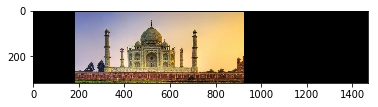

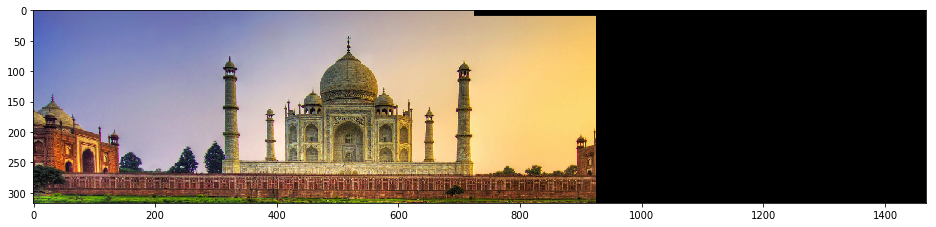

1


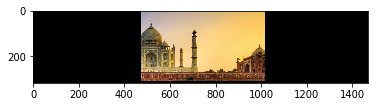

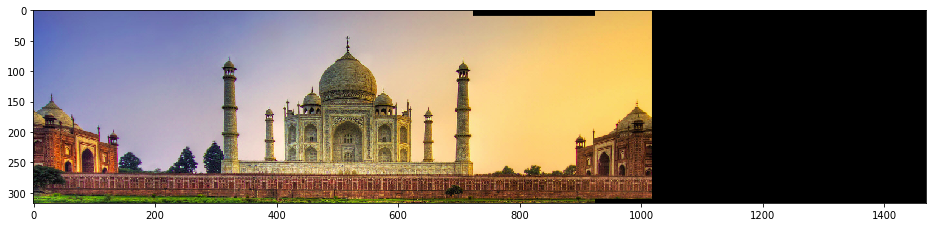

2


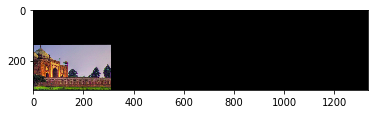

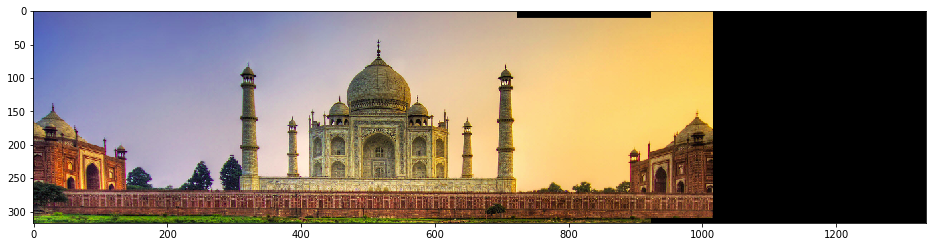

3


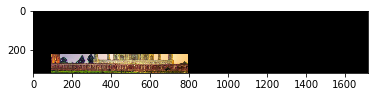

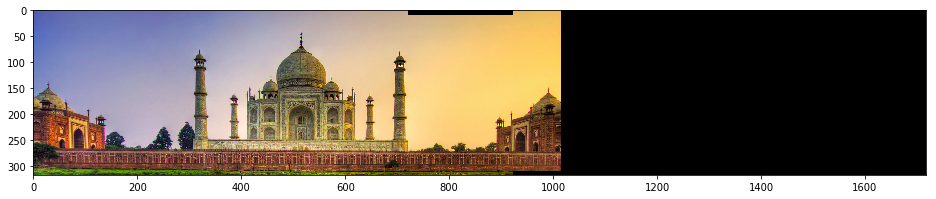

4


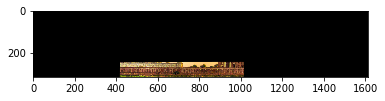

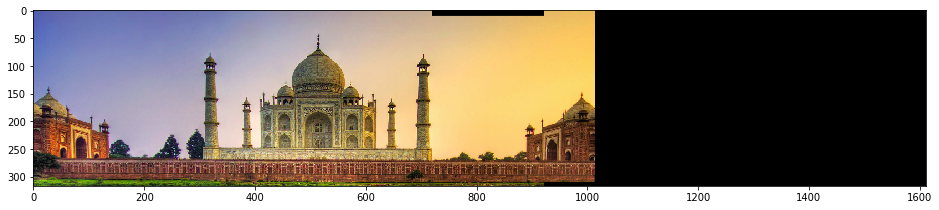

In [12]:
nm = './images/image_mosaicing/2/'
fileNames, images = get_input(nm)
surf = cv2.xfeatures2d.SURF_create()
img1 = images[0]
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
lnth = len(fileNames) - 1
for i in range(lnth):
    print(i)
    img2 = images[i+1]
    senital = None
    kp1, des1 = surf.detectAndCompute(img1, senital)
    kp2, des2 = surf.detectAndCompute(img2, senital)
    matches = get_matches(des1, des2)
    matchPoints, qp, tp = get_match_points(matches_error(get_matches(des1, des2)))
    rnd_nm = 'img0'
    show_matches(matches, img1, kp1, img2, kp2, i, rnd_nm)
    H = ransac(matchPoints, qp, tp)    
    
    result = get_warped_image(img1, img2, H, i, 'img0')
    img1 = result[:, 1:getSize(result), :]

0


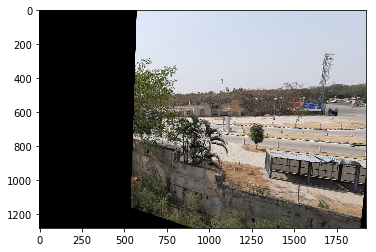

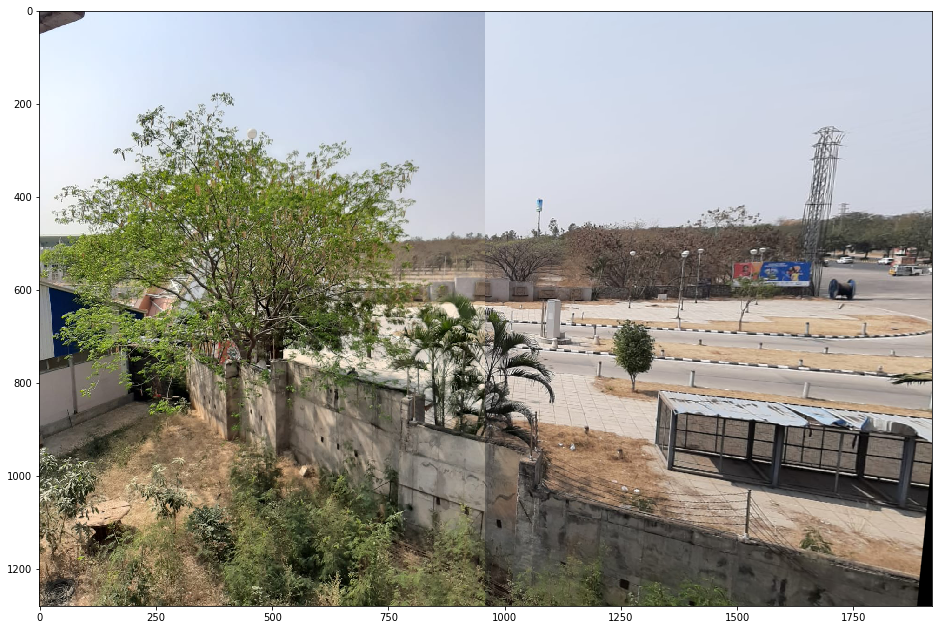

1


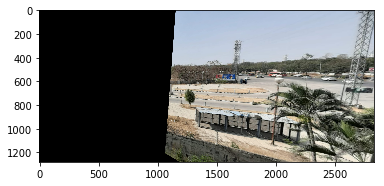

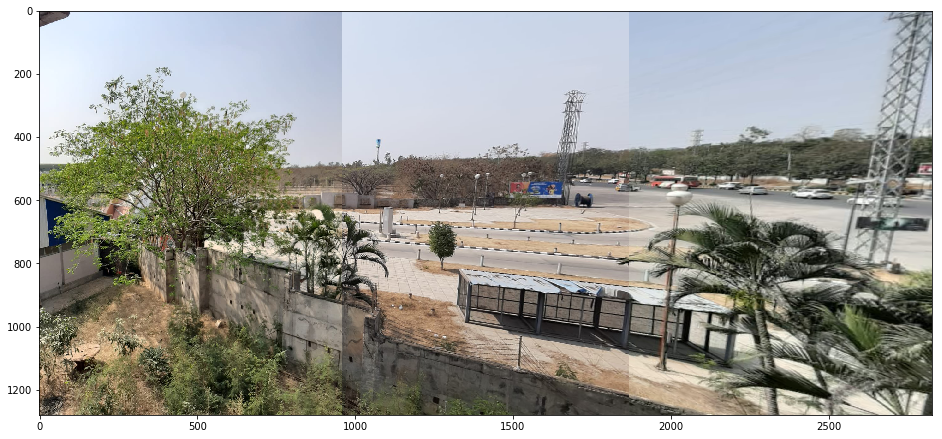

In [77]:
import cv2
nm = './images/my_images/'
fileNames, images = get_input(nm)
surf = cv2.xfeatures2d.SURF_create()
img1 = images[0]
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
lnth = len(fileNames) - 1
for i in range(lnth):
    print(i)
    img2 = images[i+1]
    senital = None
    kp1, des1 = surf.detectAndCompute(img1, senital)
    kp2, des2 = surf.detectAndCompute(img2, senital)
    matches = get_matches(des1, des2)
    matchPoints, qp, tp = get_match_points(matches_error(get_matches(des1, des2)))
    rnd_nm = 'img0'
    show_matches(matches, img1, kp1, img2, kp2, i, rnd_nm)
    H = ransac(matchPoints, qp, tp)    
    
    result = get_warped_image(img1, img2, H, i, 'img0')
    img1 = result[:, 1:getSize(result), :]

## Stereo Correspondence

In [36]:
def getImages(path):
    img = cv2.imread(path)
    h,w,c = img.shape
    w_new = w//2

    img_l = img[:,:w_new,:]
    img_r = img[:,w_new:,:]
#     print(img_l.shape)
#     print(img_r.shape)
    plt.subplot(1,2,1)
    plt.title("Left Image")
    plt.imshow(img_l)
    
    plt.subplot(1,2,2)
    plt.title("Right Image")
    plt.imshow(img_r)
    plt.show()
    return img_l, img_r


In [37]:
def SIFT_Detect(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img_with_kps = img.copy()
    sift_descriptor = cv2.xfeatures2d.SIFT_create()
    step_size = 10
    
    keypoints = []
    for y in range(0, img.shape[0], step_size):
        for x in range(0, img.shape[1], step_size):
            keypoints.append(cv2.KeyPoint(x, y, step_size))
        
    keypoints, description = sift_descriptor.compute(img, keypoints)
    kps = np.float32([kp.pt for kp in keypoints])
    img_with_kps = cv2.drawKeypoints(img,keypoints,img, color=(93, 255, 0),flags=0)
    return img_with_kps, kps, description;


In [38]:
def plotImage(imgA, title):
    plt.figure()
    plt.imshow(imgA)
    plt.title(title)

In [39]:
def matchKeypoints(desA, desB, ratio, k):
    FLANN_INDEX_KDTREE = 0
    imgA_idxs, imgB_idxs = [], []    
    index_params, search_params = dict(algorithm = 0, trees = 5), dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    rawMatches = flann.knnMatch(desA,desB,k)
    for m in rawMatches:
        if m[0].distance >= m[1].distance * ratio:
            f=0
        else:
            imgB_idxs.append(m[0].queryIdx)
            imgA_idxs.append(m[0].trainIdx)
            
    return imgA_idxs, imgB_idxs


In [40]:
def ComputeMatches(imgA, kpsA, imgA_idxs, imgB, kpsB, imgB_idxs):
    (hA, wA) = imgA.shape[:2]
    (hB, wB) = imgB.shape[:2]
    bmatch = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    bmatch[0:hA, 0:wA] = imgA
    bmatch[0:hB, wA:] = imgB
    
    for (i, j) in zip(imgA_idxs, imgB_idxs):
        x_a,y_a = int(kpsA[j][0]),int(kpsA[j][1])
        ptA = (x_a, y_a)
        x_b,y_b = int(kpsB[i][0])+wA,int(kpsB[i][1])
        ptB = (x_b, y_b)
        
        cv2.line(bmatch, ptA, ptB, (0, 255, 0), 1)
    return bmatch

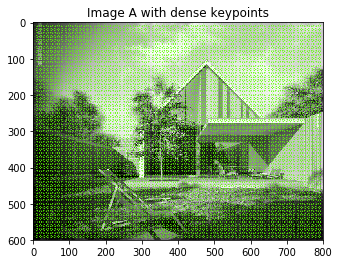

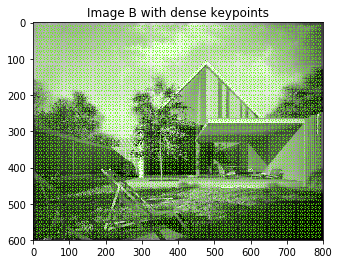

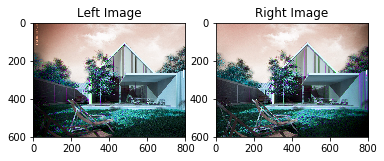

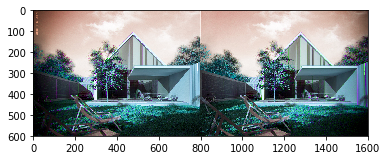

In [41]:
exc = 0
path = './images/stereo_images/1.jpg'
size = (320,320)
img_l,img_r = getImages(path)
plt.figure()
img = cv2.imread(path)
plt.imshow(img)
plt.show()

In [42]:
imgl_kps, kpsl , desl = SIFT_Detect(img_l)
plotImage(imgl_kps,"Image A with dense keypoints")
imgr_kps, kpsr , desr = SIFT_Detect(img_r)
plotImage(imgr_kps,"Image B with dense keypoints")


In [43]:
imgl_idxs, imgr_idxs = matchKeypoints(desl, desr,0.75,2)


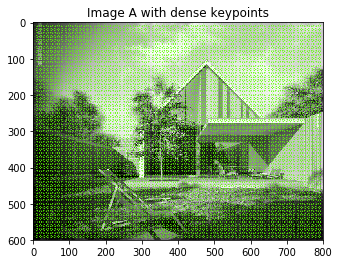

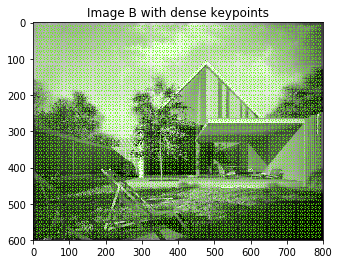

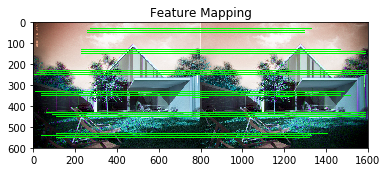

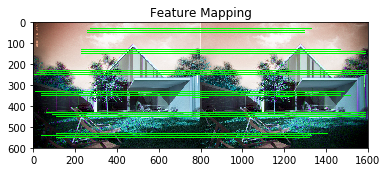

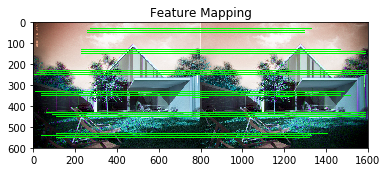

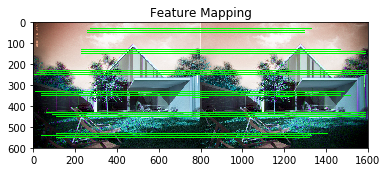

In [49]:
bmatch = ComputeMatches(img_l, kpsl, imgl_idxs, img_r, kpsr, imgr_idxs)
plotImage(bmatch,"Feature Mapping")
plt.show()

In [54]:
from random import randint
def IntensityMatching(left_img, right_img, windowsz, max_offset):
    left_img, right_img = cv2.cvtColor(left_img,cv2.COLOR_BGR2GRAY),cv2.cvtColor(right_img,cv2.COLOR_BGR2GRAY)
    left,right = np.asarray(left_img),np.asarray(right_img)    
    h, w = left_img.shape  
    bmatch = np.hstack((left_img,right_img))
    left_img,right_img = np.asarray(left_img), np.asarray(right_img)
    
    # Depth (or disparity) map
    depth, windowsz_half = np.zeros((h, w), np.uint8), int(windowsz / 2)    
    
    imgApts, imgBpts = [] , []
    inf = 99999
    for y in range(windowsz_half, h - windowsz_half):             
        for x in range(windowsz_half, w - windowsz_half):
            prev_ssd,best_offset = inf, 0

            for offset in range(max_offset):               
                 
                ssd = 0                            
                ssd_temp = ssd
                for v in range(-windowsz_half, windowsz_half):
                    for u in range(-windowsz_half, windowsz_half):
                        ssd += (int(left_img[y+v, x+u-10]) - int(right_img[y+v, (x+u-10) - offset]))**2  
                   
                if ssd < prev_ssd:
                    prev_ssd = ssd
                    best_offset = offset
            t1, t2 = randint(1,17), randint(1,17)
    
            if best_offset >= 7 and y%t1==0 and x%t2 == 0:            
                ptA = (x,y)
                ptB = (int(x-best_offset+w),y)
                imgApts.append([y,x])
                imgBpts.append([y,x-best_offset+w])
                cv2.line(bmatch, ptA, ptB, (0, 255, 0), 1)
            depth[y, x] = best_offset * 255 / max_offset
    
    return depth, bmatch, imgApts, imgBpts

In [56]:
depth, match , imgApts, imgBpts = IntensityMatching(img_l, img_r, 5, 30)
plotImage(depth,"Depth Map")
plotImage(match,"Matching Points")


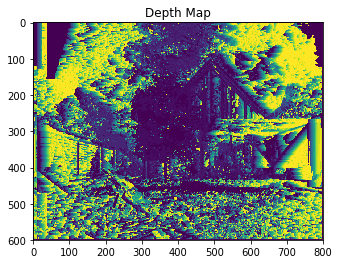

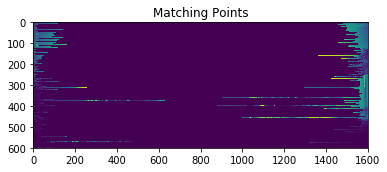

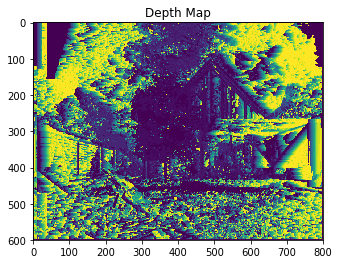

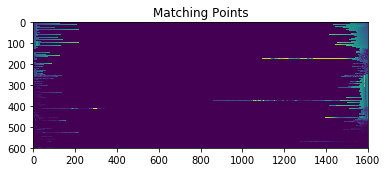

In [57]:
plt.show()

In [58]:
def DP_matching(leftimg, rightimg,wins,occlusionConstant = 0.1):
    h, w = leftimg.shape
    
    disparity,dsi =np.zeros((h-wins, w-wins+exc)), np.zeros((w-wins, w-wins+ exc))
    for y in range(1,h-wins):
        C = np.zeros((w-wins, w-wins))
        Pointers = np.zeros((w-wins, w-wins))
        
        for leftX in range(1,w-wins+ exc):
            leftPatch = leftimg[y:y +wins + exc - 1,leftX : leftX + wins + exc - 1] 
        
        for rightX in range(1,w-wins):
            rightPatch = rightimg[y : y + wins + exc - 1, rightX : rightX + wins + exc - 1]
            diffSq = (leftPatch - rightPatch)**2


            SSE = np.sum(np.sum(diffSq.T));
            dsi[rightX][leftX] = SSE;
            
        dsi = dsi/np.max(np.max(dsi));
    
        for i in range(2,w-wins+exc):
            C[i][1] = C[i-1][1] + occlusionConstant
            C[1][i] = C[1][i-1] + occlusionConstant
            Pointers[i][1] = 2
            Pointers[1][i] = 3
            
        for i in range(2,w-wins+exc):
            for j in range(2,w-wins+exc):
                c1 = C[i-1][j-1] + dsi[i][j]
                c2 = C[i-1][j] + occlusionConstant
                c3 = C[i][j-1] + occlusionConstant
                if(C[i][j] > c1):
                    C[i][j] = c1
                    Pointers[i][j] = 1
                if(C[i][j] > c2):
                    C[i][j] = c2
                    Pointers[i][j] = 2
                if(C[i][j] > c3):
                    C[i][j] = c3
                    Pointers[i][j] = 3
                
        pathy,pathx = [],[]
        for i in range(w-wins+exc-1,exc,-1):
            for j in range(w-wins+exc-1,exc,-1):
                if(Pointers[i][j]==2):
                    i=i-1
                elif(Pointers[i][j]==3):
                    j=j-1
                else:
                    i = i-1
                    j = j-1
                pathx.append(i)
                pathy.append(j)
                
        newScanline = np.zeros((w-wins,1))
        
        for zX in range(1, len(pathx)-1):
            xLoc = pathx[zX]
            yLoc = pathy[zX]
            if(zX < len(pathx)):
                if( xLoc == pathx[zX+1] + 1):
                    if(yLoc == pathy[zX+1] + 1):
                        newScanline[xLoc] = math.sqrt((xLoc - yLoc)** 2)     
            elif(~(zX < len(pathx) and xLoc == pathx[zX+1] + 1 and yLoc == pathy[zX+1] + 1)):
                newScanline[xLoc] = 0
        newScanline = newScanline.flatten()
        disparity[y, :] = newScanline;
    disparity = disparity / np.max(np.max(disparity))

    return disparity


## rectifying images

In [78]:
def img_rectify(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()

    kp1, desc1 = sift.detectAndCompute(img1,None)
    kp2, desc2 = sift.detectAndCompute(img2,None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = {'algorithm': FLANN_INDEX_KDTREE, 'trees': 10}
    search_params = {'checks': 50}
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)

    pts1 = []
    pts2 = []
    for i, (m,n) in enumerate(matches):
        if m.distance < 0.65 * n.distance:
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, _ = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)

    _, H1, H2 = cv2.stereoRectifyUncalibrated(pts1.flatten(), pts2.flatten(), F, (img1.shape[0], img1.shape[1]), threshold=3)

    img1_rectified = cv2.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))
    img2_rectified = cv2.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))
    
    return img1_rectified, img2_rectified

In [79]:
img = cv2.imread('./images/stereo_images/1.jpg', 1)

In [80]:
img1 = img[:,:(img.shape[1]//2)]
img2 = img[:,(img.shape[1]//2):]

img1_rectified, img2_rectified = img_rectify(img1, img2)
plotImage(img1_rectified,"img 1")
plotImage(img2_rectified,"img 2")

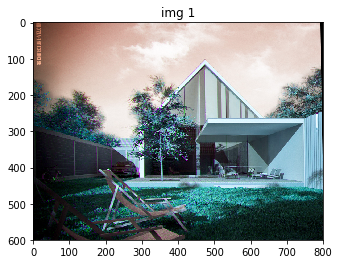

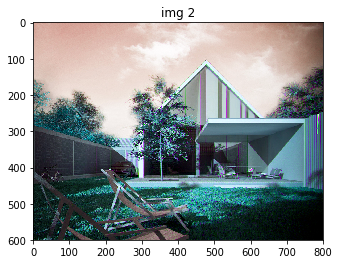

In [81]:
plt.show()

In [82]:
depth, match , imgApts, imgBpts = IntensityMatching(img1_rectified, img2_rectified, 5, 30)
plotImage(depth,"Depth Map")
plotImage(match,"Matching Points")

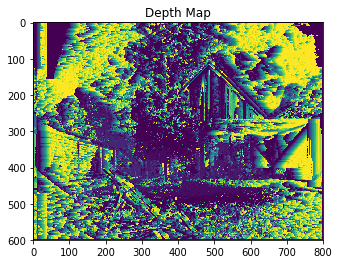

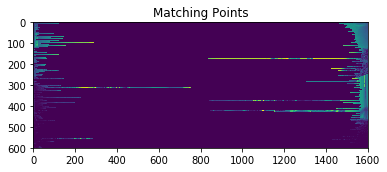

In [83]:
plt.show()

## dynamic programming solution

In [74]:
import math
img = cv2.imread('./images/stereo_images/1.jpg', 0)
img1 = img[:,:(img.shape[1]//2)]
img2 = img[:,(img.shape[1]//2):]
depth = DP_matching(img1, img2, 3)

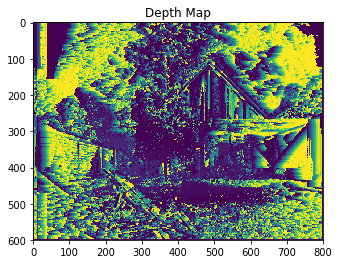

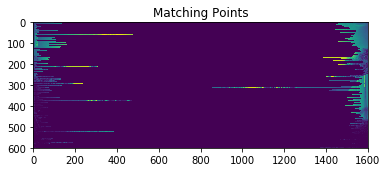

In [75]:
plt.show()